In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from dataclasses import dataclass

In [80]:
class Gradient_Estimation():

    def gradient_theta(theta, X):
        '''

        Estimate gradient with respect to theta given random input (vectorized across reps)

        theta: decision-vector for each rep  (n_rep, d_theta)
        X: random elements (n_rep, d_X)

        return: gradient estimate (n_rep, d_theta)

        '''

    # def gradient_theta_IS(theta, mu, X_IS):


class Tilting():
    def sample():
        '''

        Sample random elements (vectorized across reps)
        n_rep: number of reps
        return: random elements (n_rep, d_X)

        '''

    def sample_IS(mu):
        '''
        Sample random elements for IS (vectorized across reps)
        mu: tilting parameter for each rep  (n_rep, d_mu)
        n_rep: number of reps
        return: random elements (n_rep, d_X)

        '''

    def likelihood_ratio(mu, X_IS):
        '''
        Compute likelihood ratio for IS (vectorized across reps)
        mu: tilting parameter for each rep  (n_rep, d_mu)
        X_IS: random elements (n_rep, d_X)
        return: likelihood ratio (n_rep,)
        '''
    

    def gradient_likelihood(mu, X):
        '''

        get gradient of likelihood function with respect to mu (vectorized across reps)

        mu: tilting parameter for each rep  (n_rep, d_mu)
        X: random elements (n_rep, d_X)

        return: gradient of the likelihood function with respect to mu (n_rep, d_mu)

        '''


def gradient_theta_IS(grad_scheme, tilt_scheme, theta, mu, X_IS):
    '''
    Estimate gradient with respect to theta using IS (vectorized across reps)

    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta: decision-vector for each rep  (n_rep, d_theta)
    mu: tilting parameter for each rep  (n_rep, d_mu)
    X_IS: random elements for IS (n_rep, d_X)

    return: gradient estimate with IS (n_rep, d_theta)

    '''

    return tilt_scheme.likelihood_ratio(mu, X_IS)[:, np.newaxis] * grad_scheme.gradient_theta(theta, X_IS)


def gradient_mu_IS(grad_scheme, tilt_scheme, theta, mu, X):

    '''
    Gradient of IS estimator with respect to mu (vectorized across reps)
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta: decision-vector for each rep  (n_rep, d_theta)
    mu: tilting parameter for each rep  (n_rep, d_mu)
    X: random elements (n_rep, d_X)
    return: gradient estimate with IS (n_rep, d_mu)

    '''
    grad = grad_scheme.gradient_theta(mu, X)  # shape (n_rep, d_theta)
    grad_norm = np.linalg.norm(grad, axis=1)    # shape (n_rep,)
    grad_likelihood = tilt_scheme.gradient_likelihood(mu, X)  # shape (n_rep,) or (n_rep, d_theta)
    
    return grad_norm[:, np.newaxis] * grad_likelihood






In [143]:
def box_projection(input,upper, lower):

    '''

    Box projection

    input: input vector (n_rep, d)
    upper: upper bound vector (d,)
    lower: lower bound vector (d,)

    return: projected vector (n_rep, d)

    '''
    return np.minimum(np.maximum(input, lower), upper)

# Algorithm 


def projected_sgd(config, grad_scheme, tilt_scheme, theta0):

    '''
    perform projected stochastic gradient descent
    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)

    return: result (n_rep, d_theta, n_step)

    '''
    # config 
    gamma = config.gamma
    alpha = config.alpha
    n_rep = config.n_rep
    n_step = config.n_step
    n_rep = config.n_rep
    theta_upper = config.theta_upper
    theta_lower = config.theta_lower
    d_theta = config.d_theta


    # store
    theta = np.repeat(theta0[np.newaxis, :], n_rep, axis=0)
    result = np.zeros((n_rep, d_theta, n_step))

    # SGD loop
    for step in range(n_step):
        alpha_step = alpha/ ((step+1) ** gamma)
        X = tilt_scheme.sample() # initial random elements (n_rep, d_X)
        grad_theta = grad_scheme.gradient_theta(theta, X)
        theta = box_projection(theta - alpha_step * grad_theta,theta_upper, theta_lower)

        result[:, :, step] = theta

    return result


def nda(config, grad_scheme, tilt_scheme, theta0):
    '''

    Perform Nesterov dual averaging

    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)

    return: result (n_rep, d_theta, n_step)

    '''
    # config 
    gamma = config.gamma
    alpha = config.alpha
    n_rep = config.n_rep
    n_step = config.n_step
    n_rep = config.n_rep
    theta_upper = config.theta_upper
    theta_lower = config.theta_lower
    d_theta = config.d_theta


    # store
    theta = np.repeat(theta0[np.newaxis, :], n_rep, axis=0)
    result = np.zeros((n_rep, d_theta, n_step))
    g_sum = np.zeros((n_rep, d_theta))

    # NDA loop
    for step in range(n_step):
        alpha_step = alpha/ ((step+1) ** gamma)
        X = tilt_scheme.sample()
        grad_theta = grad_scheme.gradient_theta(theta, X)
        g_sum += alpha_step *grad_theta

        theta = box_projection(theta0 - g_sum, theta_upper, theta_lower)
        result[:, :, step] = theta

    return result


def nda_IS(config, grad_scheme, tilt_scheme, theta0, mu0):
    ''' 
    Perform Nesterov dual averaging with importance sampling

    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)
    mu0: initial tilting parameter (d_mu,)
    
    
    return: result (n_rep, d_theta, n_step)
    '''

    # config 
    gamma = config.gamma
    alpha = config.alpha
    n_rep = config.n_rep
    n_step = config.n_step
    n_rep = config.n_rep
    theta_upper = config.theta_upper
    theta_lower = config.theta_lower
    d_theta = config.d_theta
    d_mu = config.d_mu


    # store
    theta = np.repeat(theta0[np.newaxis, :], n_rep, axis=0)
    mu = np.repeat(mu0[np.newaxis, :], n_rep, axis=0)
    result_theta = np.zeros((n_rep, d_theta, n_step))
    result_mu = np.zeros((n_rep, d_mu, n_step))
    g_sum_theta = np.zeros((n_rep, d_theta))
    g_sum_mu = np.zeros((n_rep, config.d_mu))

    # NDA loop
    for step in range(n_step):
        alpha_step = alpha/ ((step+1) ** gamma)
        X_IS = tilt_scheme.sample_IS(mu)
        X = tilt_scheme.sample()
        grad_theta = gradient_theta_IS(grad_scheme, tilt_scheme, theta, mu, X_IS)
        grad_mu = gradient_mu_IS(grad_scheme, tilt_scheme, theta, mu, X)

        g_sum_theta += alpha_step *grad_theta
        g_sum_mu += alpha_step *grad_mu/1000  # scale to avoid too large updates

        theta = box_projection(theta0 - g_sum_theta, theta_upper, theta_lower)
        mu = box_projection(mu0 - g_sum_mu, config.mu_upper, config.mu_lower)

        result_theta[:, :, step] = theta
        result_mu[:, :, step] = mu

    return result_theta, result_mu
    


In [144]:
def plot_norm_deviate(results):
    '''

    take results from different algorithm and plot norm of deviate 

    results: dictionary of results from different algorithms
             key: algorithm name
             value: result (n_rep, d_theta, n_step)

    plot norm of deviate over iterations for each algorithm with confidence interval
    
    '''
    plt.figure()
    for key in results.keys():
        result = results[key]
        n_rep = result.shape[0]
        n_step = result.shape[2]
        norm_deviate = np.linalg.norm(result - result[:, :, -1][:, :, np.newaxis], axis=1)  # shape (n_rep, n_step)
        mean_norm_deviate = np.mean(norm_deviate, axis=0)
        std_norm_deviate = np.std(norm_deviate, axis=0)
        ci_upper = mean_norm_deviate + 1.96 * std_norm_deviate / np.sqrt(n_rep)
        ci_lower = mean_norm_deviate - 1.96 * std_norm_deviate / np.sqrt(n_rep)

        plt.plot(mean_norm_deviate, label=key)
        plt.fill_between(range(n_step), ci_lower, ci_upper, alpha=0.2)

    plt.xlabel('Iteration')
    plt.ylabel('Norm of Deviate')
    plt.legend()
    plt.title('Norm of Deviate over Iterations')
    plt.show()

    

In [145]:
def experiment_1(config, grad_scheme, tilt_scheme, theta0, mu0):
    '''

    Run experiment 1 comparing different algorithms

    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)
    mu0: initial tilting parameter (d_mu,)

    return: results dictionary
            key: algorithm name
            value: result (n_rep, d_theta, n_step)

    '''
    results = {}
    results_mu = {}

    # Projected SGD
    results['Projected SGD'] = projected_sgd(config, grad_scheme, tilt_scheme, theta0)

    # Nesterov Dual Averaging
    results['Nesterov Dual Averaging'] = nda(config, grad_scheme, tilt_scheme, theta0)

    # Nesterov Dual Averaging with IS
    result_theta, result_mu = nda_IS(config, grad_scheme, tilt_scheme, theta0, mu0)
    results['NDA with IS']  = result_theta
    results_mu['NDA with IS'] = result_mu

    # plot results
    plot_norm_deviate(results)
    plot_norm_deviate(results_mu)
    
    return results, results_mu

In [146]:

class Normal_Expo_Tilting(Tilting):
    '''

    Tilting scheme for multivariate standard normal distribution with exponential tilting
    
    d_X: dimension of random input
    n_rep: number of repetitions

    
    '''
    def __init__(self, config):
        self.d_X = config.d_X
        self.n_rep = config.n_rep
        np.random.seed(config.seed)

    def sample(self):
        return np.random.normal(0, 1, (self.n_rep, self.d_X))

    def sample_IS(self, mu):
        # mu is (n_rep, d_mu) and d_mu = d_X
        return np.random.normal(mu, 1)

    def likelihood_ratio(self, mu, X_IS):
        # mu is (n_rep, d_mu) and d_mu = d_X
        exponent = 0.5 * np.sum(mu**2, axis=1) - np.sum(mu * X_IS, axis=1)
        return np.exp(exponent)

    def gradient_likelihood(self, mu, X):
        # mu is (n_rep, d_mu) and d_mu = d_X
        return (mu- X)* self.likelihood_ratio(mu, X)[:, np.newaxis]






In [178]:
@dataclass
class ExperimentConfig:
    n_rep: int         # number of repetitions
    n_step: int       # number of iterations
    d_X: int          # dimension of random input
    d_theta: int      # dimension of theta
    d_mu: int         # dimension of mu
    alpha: float      # step size
    gamma: float      # decay rate
    seed: int     # random seed

    theta_upper: np.ndarray  # shape (d_theta,)
    theta_lower: np.ndarray  # shape (d_theta,)
    mu_upper: np.ndarray     # shape (d_mu,)
    mu_lower: np.ndarray     # shape (d_mu,)


config = ExperimentConfig(
    n_rep=10,
    n_step=10000,
    d_X=10,
    d_theta=1,
    d_mu=10,
    alpha=1.,
    gamma=0.6,
    seed=42,

    
    theta_upper=np.ones(1) * 1000.0,
    theta_lower=-np.ones(1) * 10.0,
    mu_upper=np.ones(10) * 2.0,
    mu_lower=-np.ones(10) * 2.0,
    
)


# CVaR Setup

## Experiment 1: Almost sure convergence

In [179]:
# port folio config
@dataclass
class PortfolioConfig:
    p: float # quantile 
    r: float # risk-free level
    q: float # dividend rate
    sigma: float
    T: float # time horizon
    S0: float # initial stock price (assume that all assets have the same initial price)
    K: float # strike price
    delta_t: float # risk period
    n_asset: int # number of underlying assets
    n_call: float # number of call options on each asset
    n_put: float # number of put options on each asset
    

port_config = PortfolioConfig(p =0.9999,
                                r=0.05,
                                q=0.0,
                                sigma=0.3,
                                T=.5,
                                S0=100.0,
                                K=100.0,
                                delta_t=0.04,
                                n_asset=10,
                                n_call = 10,
                                n_put = 5
                                )


In [180]:
class Cvar_Grad_Estimation(Gradient_Estimation):
    '''

    Gradient estimation scheme for CVaR objective

    d_theta: dimension of theta
    n_rep: number of repetitions
    alpha_cvar: CVaR level

    '''
    def __init__(self, port_config: PortfolioConfig):
        self.config = port_config
        self.n_asset = port_config.n_asset
        self.n_call = port_config.n_call
        self.n_put = port_config.n_put
        self.S0 = port_config.S0
        self.K = port_config.K
        self.T = port_config.T
        self.r = port_config.r
        self.q = port_config.q
        self.delta_t = port_config.delta_t
        self.sigma = port_config.sigma
        self.lamb = 1.0 / (1.0 - port_config.p)

        

    def gradient_theta(self, theta, X):
        '''
        Estimate stochastic gradient with respect to theta given random input (vectorized across reps)
        theta: decision-vector for each rep  (n_rep, d_theta)
        X: random elements (n_rep, d_X)
        return: gradient estimate (n_rep, d_theta)

        '''

        n_rep = X.shape[0]
        loss = self.portfolio_loss( X)  # shape (n_rep,)
        # make loss ( n_rep, 1)
        loss = loss[:, np.newaxis]

        grad = 1. - self.lamb * (loss >= theta).astype(float)  # shape (n_rep, d_theta)

        return grad     # shape (n_rep, d_theta)


    @staticmethod
    def blsprice(S, K , T, r, q, sigma):
        ''' 
        Black-Scholes price for European call option. For vector S, we assume that each asset has the same K, T, r, q, sigma.
        S: stock price (scalar or vector)
        K: strike price (scalar)
        T: time to maturity (scalar)
        r: risk-free rate (scalar)
        q: dividend rate (scalar)
        sigma: volatility (scalar)

        return: (call, put) with same shape as S (scalar in -> scalar out).
        '''


        S = np.asarray(S, dtype=float)
        
        # check if S is less than 0
        if np.any(S <= 0):
            raise ValueError("Stock price S must be positive.")


        sqrtT = np.sqrt(T)
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
        d2 = d1 - sigma * sqrtT

        disc_r = np.exp(-r * T)
        disc_q = np.exp(-q * T)

        call = S * disc_q * norm.cdf(d1) - K * disc_r * norm.cdf(d2)
        put  = K * disc_r * norm.cdf(-d2) - S * disc_q * norm.cdf(-d1)

        # preserve scalar in -> scalar out
        if call.ndim == 0:
            return call.item(), put.item()
        return call, put



    def portfolio_loss(self,  X):
        '''
        Compute portfolio loss given theta and random elements X
    

        X: random elements (n_rep, d_X)
        return: portfolio loss (n_rep,)
        '''

        call0, put0 = self.blsprice(self.S0, self.K, self.T, self.r, self.q, self.sigma)

        Phi0 = (self.n_call * call0 + self.n_put * put0)* self.n_asset

        C_tilde = self.S0 *np.sqrt(self.delta_t) * self.sigma #( scalar in this case)
        S_X = self.S0 + C_tilde * X # shape (n_rep, d_X)

        call, put = self.blsprice(S_X, self.K, self.T - self.delta_t, self.r, self.q, self.sigma)

        Phi = (self.n_call * np.sum(call, axis = 1) + self.n_put * np.sum(put, axis = 1))  # shape (n_rep,)

        loss = Phi0 -Phi

        return loss

        


In [181]:
ET_scheme = Normal_Expo_Tilting(config)

cvar_grad_scheme = Cvar_Grad_Estimation(port_config)

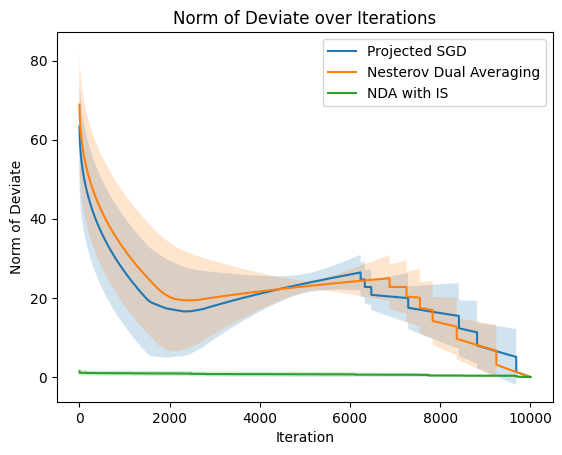

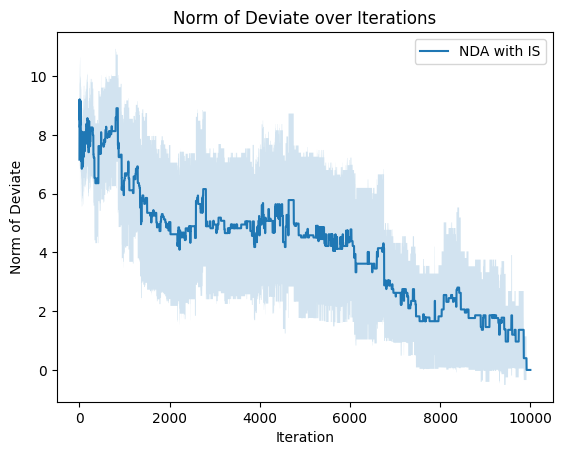

In [182]:
results_theta_1, results_mu_1 = experiment_1(config,
                     cvar_grad_scheme,
                      ET_scheme, 
                      theta0=np.ones(config.d_theta)*300, 
                      mu0=np.zeros(config.d_mu))

In [184]:
results_theta_1

{'Projected SGD': array([[[299.        , 298.34024604, 297.82296419, ..., 202.43184068,
          202.42785937, 202.42387829]],
 
        [[299.        , 298.34024604, 297.82296419, ..., 202.43184068,
          202.42785937, 202.42387829]],
 
        [[299.        , 298.34024604, 297.82296419, ..., 254.11831334,
          254.11433203, 254.11035096]],
 
        ...,
 
        [[299.        , 298.34024604, 297.82296419, ..., 246.58558391,
          246.5816026 , 246.57762153]],
 
        [[299.        , 298.34024604, 297.82296419, ..., 243.0094466 ,
          243.00546529, 243.00148422]],
 
        [[299.        , 298.34024604, 297.82296419, ..., 254.82084176,
          254.81686045, 254.81287938]]]),
 'Nesterov Dual Averaging': array([[[299.        , 298.34024604, 297.82296419, ..., 202.43184068,
          202.42785937, 202.42387829]],
 
        [[299.        , 298.34024604, 297.82296419, ..., 250.70318497,
          250.69920366, 250.69522259]],
 
        [[299.        , 298.34024604,

## Experiment 2: Active Constraints

## Experiment 3: Optimal Variance 